In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
MAIN_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/"
images_df = pd.read_csv(MAIN_DIR+'images.csv')
styles_df = pd.read_csv(MAIN_DIR+'styles.csv', on_bad_lines='skip')

In [3]:
images_df.head()

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [4]:
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [5]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName   filename  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg

In [6]:
image_files = os.listdir(MAIN_DIR+'images')

In [7]:
styles_df['present'] = styles_df['filename'].apply(lambda x: x in image_files)
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName   filename  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg   
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg   
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg   
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg   

   present  
0     True  
1     True  
2     True  
3     True  
4     True

In [8]:
styles_df['present'].value_counts()

True     44419
False        5
Name: present, dtype: int64

In [9]:
styles_df = styles_df[styles_df['present']].reset_index(drop=True)

In [10]:
styles_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName   filename  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg   
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg   
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg   
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg   

   present  
0     True  
1     True  
2     True  
3     True  
4     True

In [11]:
styles = styles_df.sample(10000).reset_index(drop=True)
styles.head()

id gender masterCategory subCategory articleType baseColour  season  \
0  26364  Women        Apparel  Bottomwear      Skirts       Grey  Summer   
1  14801  Women    Accessories        Bags    Handbags      Black  Summer   
2  20221    Men        Apparel     Topwear    Sweaters   Charcoal    Fall   
3   1662    Men        Apparel     Topwear     Jackets  Navy Blue    Fall   
4  35246    Men    Accessories       Socks       Socks      White  Summer   

     year   usage                                 productDisplayName  \
0  2012.0  Formal                             Arrow Woman Grey Skirt   
1  2011.0  Casual  United Colors of Benetton Women Solid Black Ha...   
2  2011.0  Casual                  Wrangler Men Rib Charcoal Sweater   
3  2012.0  Sports                    Nike Men Blue Windrunner Jacket   
4  2012.0  Casual                  Manchester United Men White Socks   

    filename  present  
0  26364.jpg     True  
1  14801.jpg     True  
2  20221.jpg     True  
3   1662.jpg     True  
4  35246.jpg     True

In [12]:
IMG_SIZE = (224,224)
datagen = ImageDataGenerator(rescale=1/255.)
generator = datagen.flow_from_dataframe(dataframe=styles,
                                        directory=MAIN_DIR+'images',
                                        target_size=IMG_SIZE,
                                        x_col='filename',
                                        class_mode=None,
                                        batch_size=32,
                                        shuffle=False)

Found 10000 validated image filenames.


In [13]:
base_model = VGG16(include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False 

input_layer = Input(shape=IMG_SIZE+(3,))
x = base_model(input_layer)
output = GlobalAveragePooling2D()(x)

embeddings = Model(input_layer, output)
embeddings.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
X = embeddings.predict(generator, verbose=1)

313/313 [==============================] - 310s 965ms/step


In [15]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_pca = pca.fit_transform(X)

In [16]:
styles[['pc1','pc2']] = X_pca

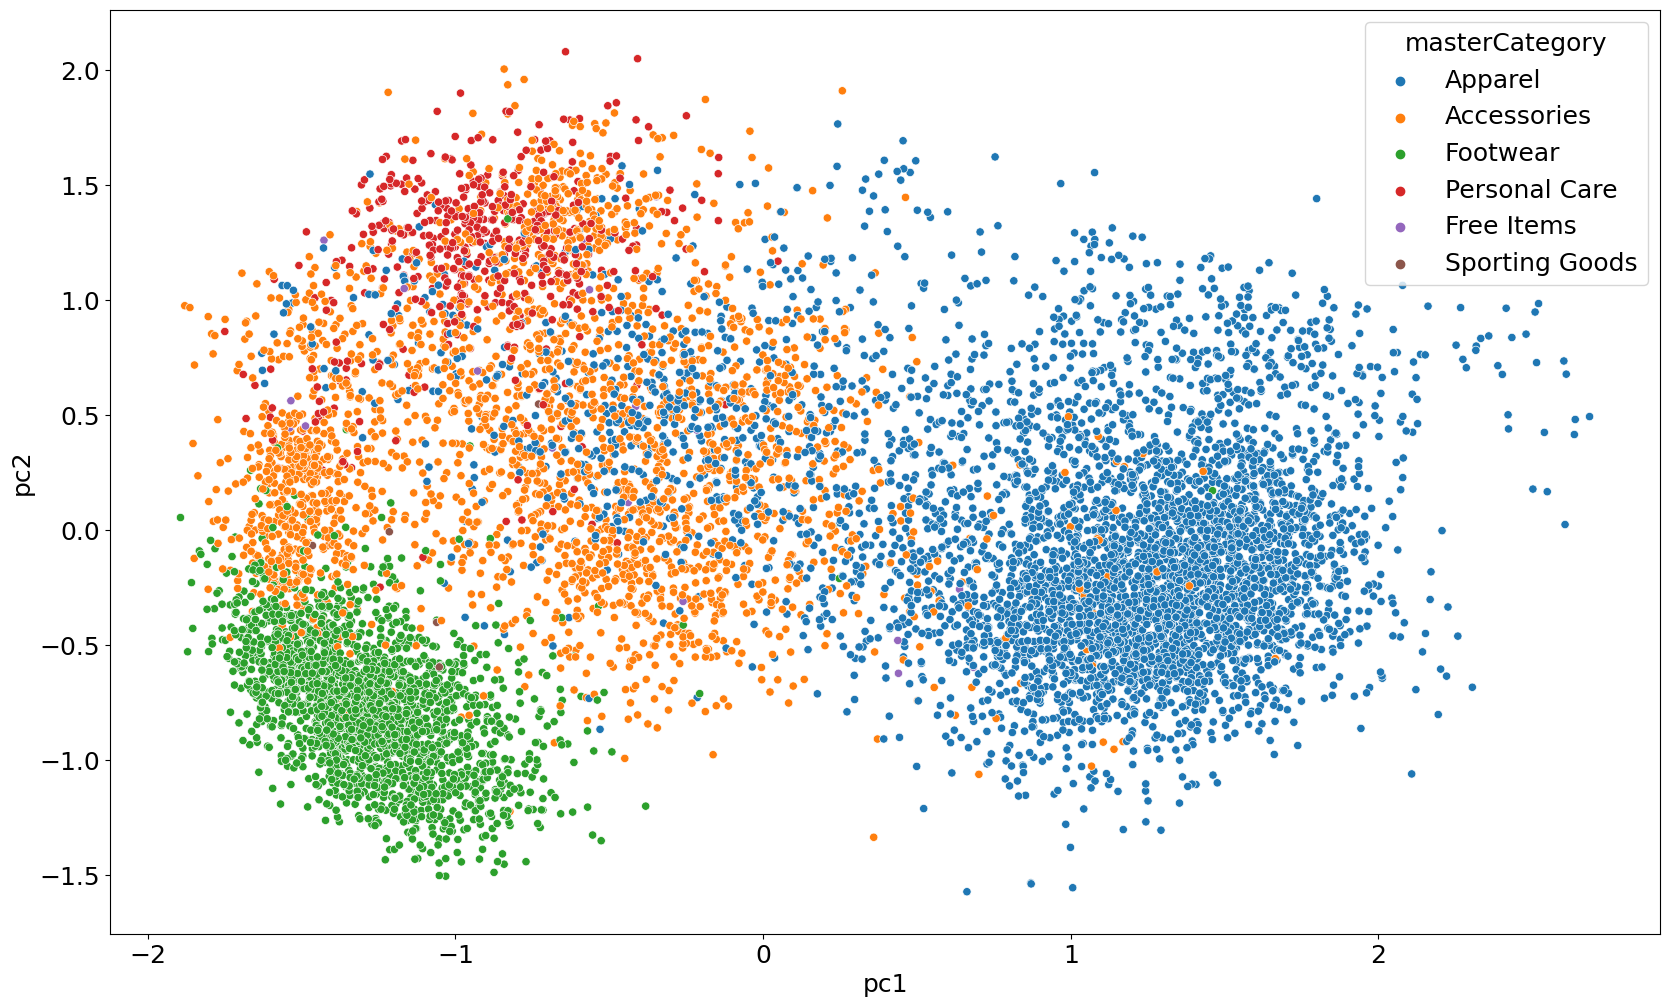

In [17]:
plt.figure(figsize=(20,12))
sns.scatterplot(x='pc1',y='pc2', data=styles, hue='masterCategory')
plt.show()

In [18]:
def read_img(image_path):
    path = MAIN_DIR + 'images/'
    image = load_img(os.path.join(path,image_path),target_size=(224,224,3))
    image = img_to_array(image)
    image = image/255.
    return image

In [19]:
import random
from sklearn.neighbors import KNeighborsClassifier
y = styles['id']

In [20]:
nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X,y)

KNeighborsClassifier(n_neighbors=7)

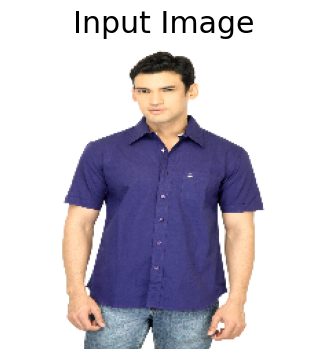

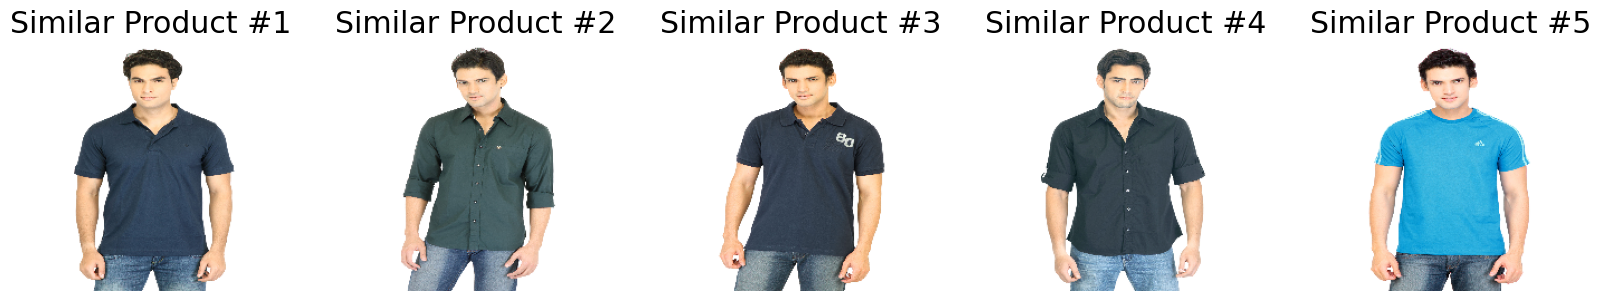

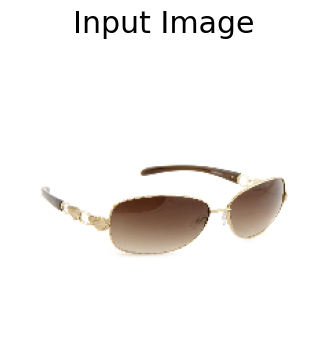

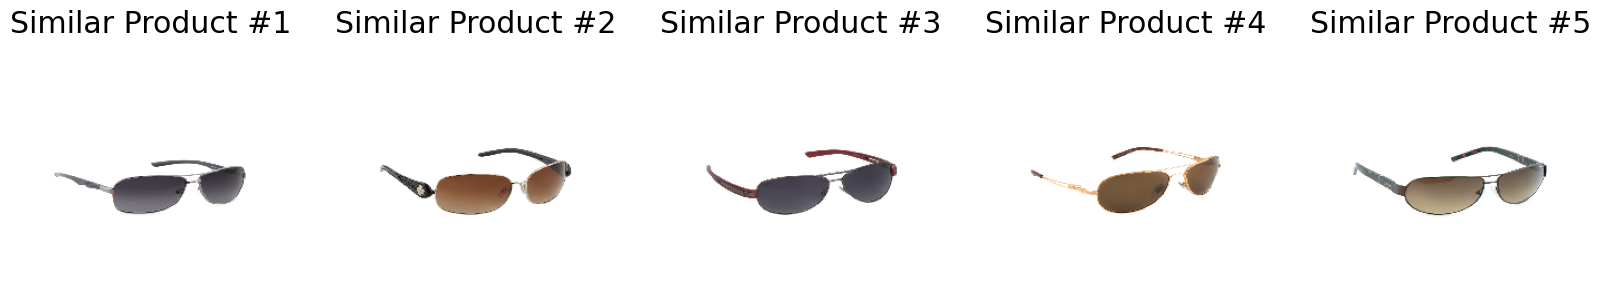

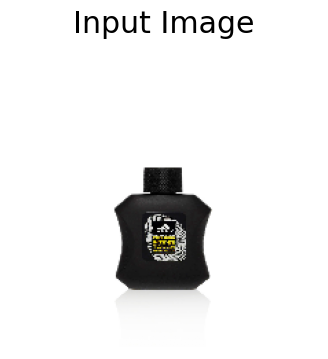

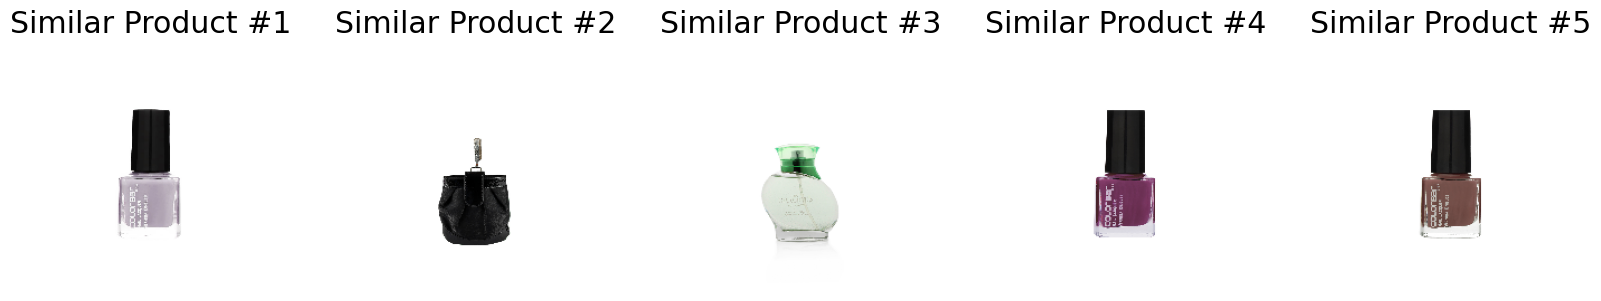

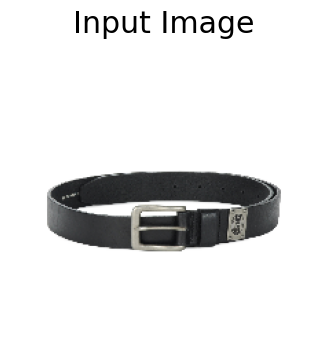

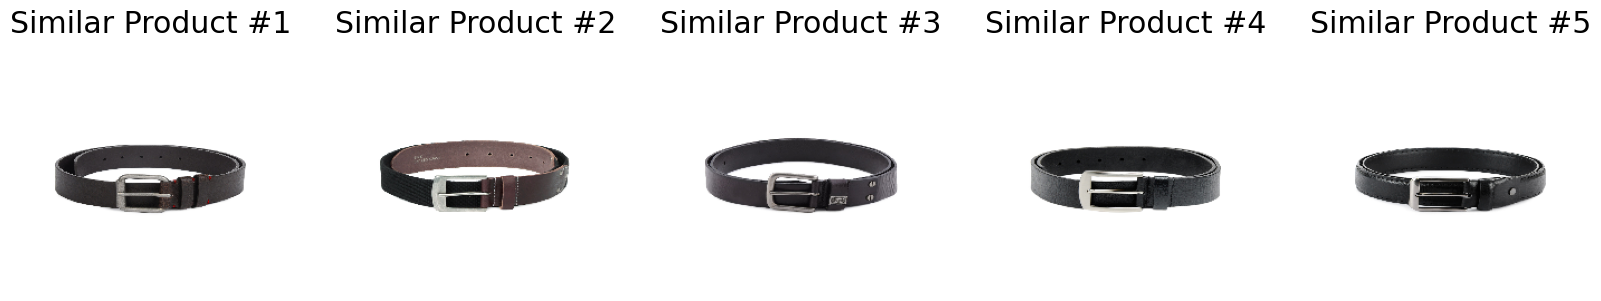

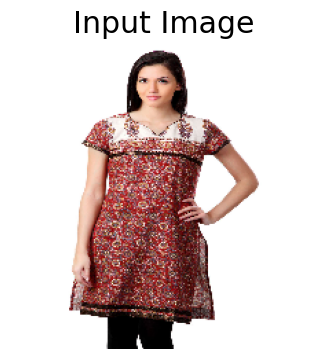

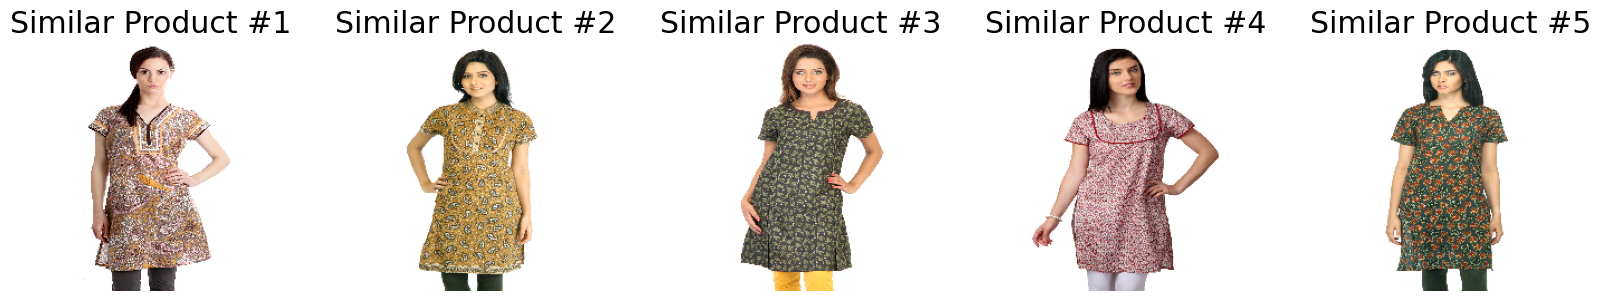

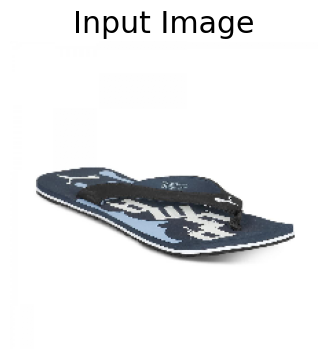

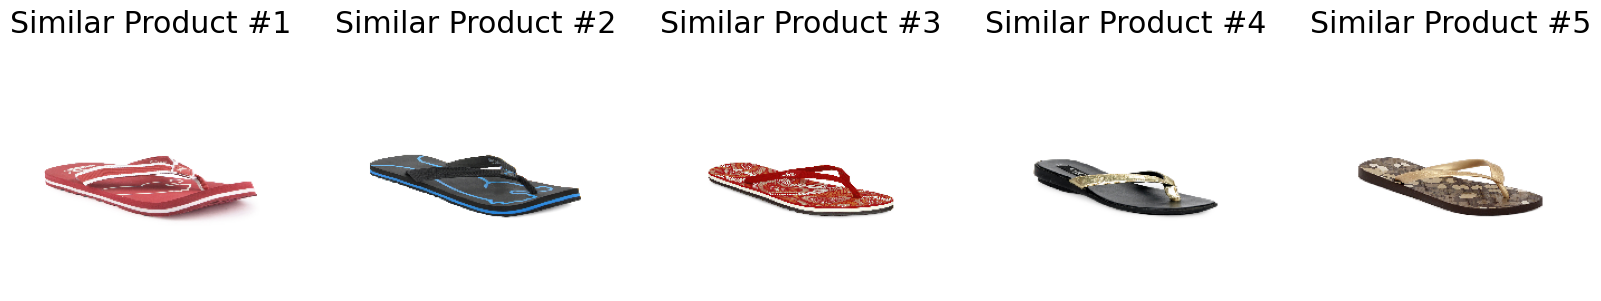

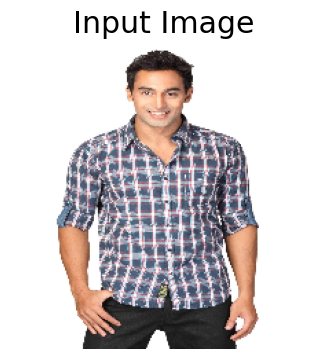

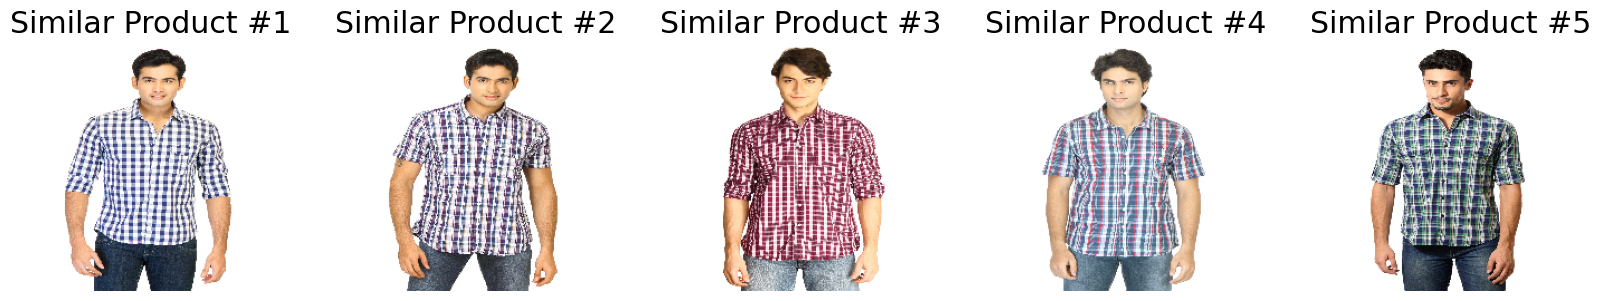

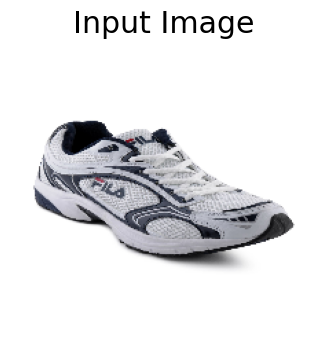

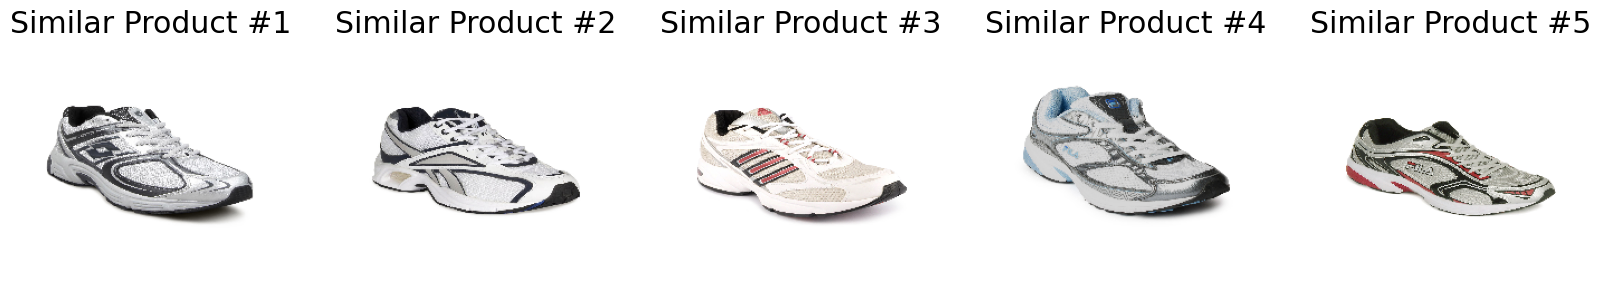

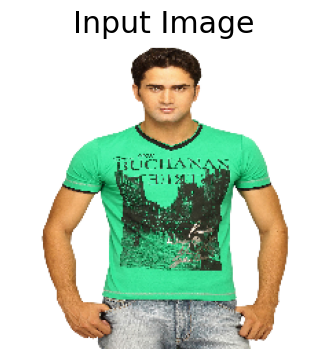

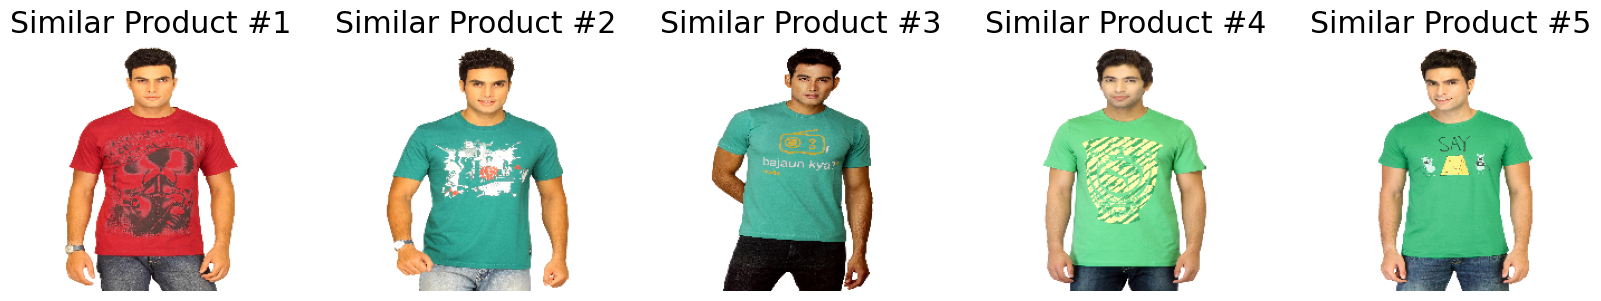

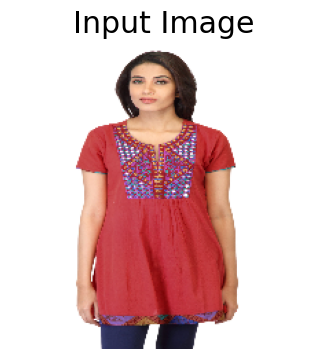

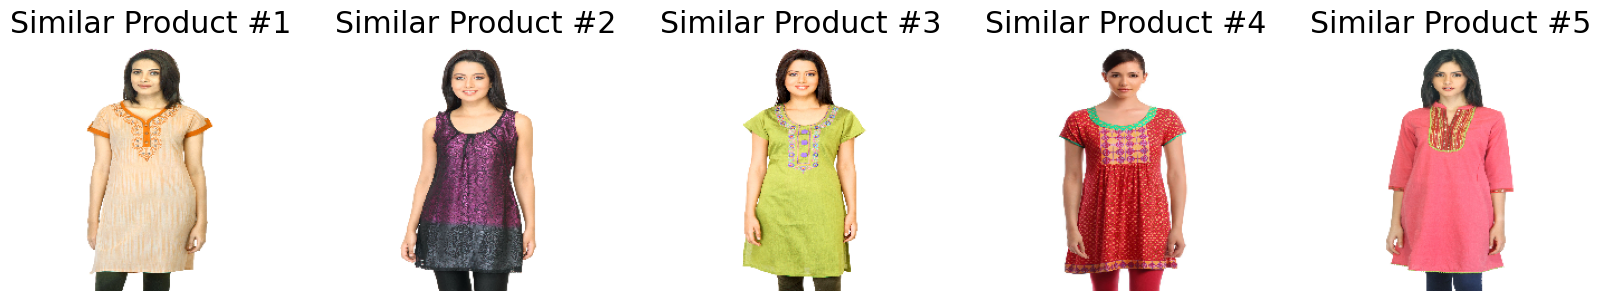

In [21]:
for _ in range(10):
    i = random.randint(0,len(styles))
    img1 = read_img(styles.loc[i,'filename'])
    dist, index = nn.kneighbors(X=X[i,:].reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(styles.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')
        plt.axis('off')